In [9]:
import os, sys

# Robustly set working directory to project root
if os.path.basename(os.getcwd()) == 'examples':
    os.chdir('../')
    print('Changed directory to project root.')

sys.path.append(os.getcwd())

# Verify dataset existence
if not os.path.exists('dataset'):
    print(f"Warning: 'dataset' folder not found in current directory: {os.getcwd()}")
else:
    print(f"Current working directory: {os.getcwd()}")

# Imports
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertPreTrainedModel, BertModel, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from utils.metrics import absa_metrics_fn as metrics_fn


Current working directory: d:\coding\python\indonlu


In [10]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(26092020)

In [11]:
class MultiAspectSentimentDataset(torch.utils.data.Dataset):
    ASPECT_DOMAIN = ['food_quality', 'service', 'price']
    LABEL2INDEX = {'negative': 0, 'neutral': 1, 'positive': 2}
    INDEX2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}
    NUM_LABELS = [3, 3, 3]
    
    def __init__(self, path, tokenizer, no_special_token=False):
        self.data = pd.read_csv(path)

        # Drop NaN values in 'review' column
        if self.data['review'].isnull().any():
            print(f"Found {self.data['review'].isnull().sum()} NaN values in 'review' column. Dropping them.")
            self.data = self.data.dropna(subset=['review']).reset_index(drop=True)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
        
    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row['review']
        labels = [self.LABEL2INDEX[row[aspect]] for aspect in self.ASPECT_DOMAIN]
        
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), text
    
    def __len__(self):
        return len(self.data)

class ABSADataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, max_seq_len=512, *args, **kwargs):
        super().__init__(dataset, *args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        label_batch = np.zeros((batch_size, 3), dtype=np.int64)
        
        sentence_batch = []
        
        for i, (subwords, labels, sentence) in enumerate(batch):
            length = min(len(subwords), max_seq_len)
            subword_batch[i, :length] = subwords[:length]
            mask_batch[i, :length] = 1
            label_batch[i] = labels
            sentence_batch.append(sentence)
            
        return torch.from_numpy(subword_batch), torch.from_numpy(mask_batch), torch.from_numpy(label_batch), sentence_batch

In [12]:
class BertForMultiLabelClassificationWeighted(BertPreTrainedModel):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.num_labels = config.num_labels_list
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifiers = torch.nn.ModuleList([torch.nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels])
        self.class_weights = class_weights # List of tensors

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = []
        for classifier in self.classifiers:
            logits.append(classifier(pooled_output))
            
        loss = 0
        if labels is not None:
            if self.class_weights:
                losses = []
                for i, (logit, weight) in enumerate(zip(logits, self.class_weights)):
                    loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
                    losses.append(loss_fct(logit.view(-1, self.num_labels[i]), labels[:, i].view(-1)))
                loss = sum(losses)
            else:
                loss_fct = torch.nn.CrossEntropyLoss()
                for i, logit in enumerate(logits):
                    loss += loss_fct(logit.view(-1, self.num_labels[i]), labels[:, i].view(-1))
                    
        return (loss, logits) if labels is not None else logits


In [13]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels_list = [3, 3, 3]

# Weights
weights_food_quality = torch.tensor([1.67, 0.92, 0.76]).float()
weights_service = torch.tensor([1.54, 0.79, 0.93]).float()
weights_price = torch.tensor([2.77, 0.51, 1.47]).float()
class_weights = [weights_food_quality, weights_service, weights_price]

# Datasets
train_dataset_path = 'dataset/fnb/multilabel/train_preprocess.csv'
valid_dataset_path = 'dataset/fnb/multilabel/valid_preprocess.csv'
test_dataset_path = 'dataset/fnb/multilabel/test_preprocess.csv'

train_dataset = MultiAspectSentimentDataset(train_dataset_path, tokenizer)
valid_dataset = MultiAspectSentimentDataset(valid_dataset_path, tokenizer)
test_dataset = MultiAspectSentimentDataset(test_dataset_path, tokenizer)

# DataLoaders
train_loader = ABSADataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = ABSADataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = ABSADataLoader(test_dataset, batch_size=16, shuffle=False)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = [w.to(device) for w in class_weights]
model = BertForMultiLabelClassificationWeighted.from_pretrained('indobenchmark/indobert-base-p1', config=config, class_weights=class_weights)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

Found 1 NaN values in 'review' column. Dropping them.


Some weights of BertForMultiLabelClassificationWeighted were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifiers.0.bias', 'classifiers.0.weight', 'classifiers.1.bias', 'classifiers.1.weight', 'classifiers.2.bias', 'classifiers.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def forward_sequence_multi_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    subword_batch, mask_batch, label_batch, sentence_batch = batch_data
    
    # Prepare inputs
    subword_batch = subword_batch.to(device)
    mask_batch = mask_batch.to(device)
    label_batch = label_batch.to(device)
    
    # Forward pass
    if is_test:
        logits = model(subword_batch, attention_mask=mask_batch, labels=None)
        loss = None
    else:
        loss, logits = model(subword_batch, attention_mask=mask_batch, labels=label_batch)
        
    # Process predictions
    # logits is a list of tensors [batch_size, num_labels] for each aspect
    list_hyp = []
    list_label = []
    
    # Iterate over batch items
    batch_size = subword_batch.shape[0]
    
    hyps_per_aspect = []
    for logit in logits:
        # logit: [batch, num_classes]
        pred = torch.max(logit, 1)[1] # [batch]
        hyps_per_aspect.append(pred.cpu().numpy())
    
    labels_per_aspect = []
    if label_batch is not None:
        for i in range(3):
            labels_per_aspect.append(label_batch[:, i].cpu().numpy())
            
    # Reorganize to [sample][aspect]
    list_hyp = []
    list_label = []
    
    for i in range(batch_size):
        sample_hyp = [hyps_per_aspect[aspect][i] for aspect in range(3)]
        list_hyp.append(sample_hyp)
        
        if label_batch is not None:
            sample_label = [labels_per_aspect[aspect][i] for aspect in range(3)]
            list_label.append(sample_label)
            
    return loss, list_hyp, list_label

In [15]:
# Training Function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    list_hyp, list_label = [], []
    
    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        optimizer.zero_grad()
        loss, hyp, label = forward_sequence_multi_classification(model, batch, MultiAspectSentimentDataset.INDEX2LABEL, device=device)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        list_hyp += hyp
        list_label += label
        
        pbar.set_description(f"Loss: {loss.item():.4f}")
        
    metrics = metrics_fn(list_hyp, list_label)
    avg_loss = total_loss/len(loader)
    metrics['loss'] = avg_loss
    print(f"Train Loss: {avg_loss:.4f} Accuracy: {metrics['ACC']:.4f} F1: {metrics['F1']:.4f}")
    return metrics

# Evaluation Function
from sklearn.metrics import f1_score

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    list_hyp, list_label = [], []
    
    pbar = tqdm(loader, leave=False)
    with torch.no_grad():
        for batch in pbar:
            loss, hyp, label = forward_sequence_multi_classification(model, batch, MultiAspectSentimentDataset.INDEX2LABEL, device=device)
            if loss is not None:
                total_loss += loss.item()
                
            list_hyp += hyp
            list_label += label
            
    # Calculate global metrics
    metrics = metrics_fn(list_hyp, list_label)
    avg_loss = total_loss/len(loader)
    metrics['loss'] = avg_loss
    print(f"Val Loss: {avg_loss:.4f} Accuracy: {metrics['ACC']:.4f} Macro F1: {metrics['F1']:.4f}")
    
    # Calculate per-aspect metrics
    num_aspects = 3
    aspect_names = MultiAspectSentimentDataset.ASPECT_DOMAIN
    
    hyp_per_aspect = [[sample[i] for sample in list_hyp] for i in range(num_aspects)]
    label_per_aspect = [[sample[i] for sample in list_label] for i in range(num_aspects)]
    
    for i, aspect in enumerate(aspect_names):
        f1 = f1_score(label_per_aspect[i], hyp_per_aspect[i], average='macro')
        print(f"  - {aspect.replace('_', ' ').title()} F1: {f1:.4f}")
        metrics[f"{aspect}_f1"] = f1
        
    return metrics


In [16]:
# Training Loop
import time
import os

n_epochs = 15
best_val_f1 = -1
save_path = 'model_absa_fnb_best'
history = []

for epoch in range(n_epochs):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{n_epochs}")
    
    train_metrics = train(model, train_loader, optimizer)
    val_metrics = evaluate(model, valid_loader)
    
    end_time = time.time()
    epoch_time = end_time - start_time
    
    # Store metrics
    record = {
        'epoch': epoch + 1,
        'time': epoch_time,
        'train_loss': train_metrics['loss'],
        'train_acc': train_metrics['ACC'],
        'train_f1': train_metrics['F1'],
        'train_rec': train_metrics['REC'],
        'train_pre': train_metrics['PRE'],
        'val_loss': val_metrics['loss'],
        'val_acc': val_metrics['ACC'],
        'val_f1': val_metrics['F1'],
        'val_rec': val_metrics['REC'],
        'val_pre': val_metrics['PRE']
    }
    history.append(record)
    
    # Save best model
    val_f1 = val_metrics['F1']
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        print(f"New best validation F1: {best_val_f1:.4f}. Saving model to {save_path}...")
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)
    print("-" * 30)

# Create DataFrame for analysis
df_history = pd.DataFrame(history)
df_history


Epoch 1/15


Train Loss: 1.1310 Accuracy: 0.8534 F1: 0.8453


Val Loss: 0.8833 Accuracy: 0.8916 Macro F1: 0.8881
  - Food Quality F1: 0.8680
  - Service F1: 0.8666
  - Price F1: 0.9201
New best validation F1: 0.8881. Saving model to model_absa_fnb_best...
------------------------------
Epoch 2/15


Train Loss: 0.6662 Accuracy: 0.9144 F1: 0.9116


Val Loss: 0.8225 Accuracy: 0.9016 Macro F1: 0.8976
  - Food Quality F1: 0.8783
  - Service F1: 0.8655
  - Price F1: 0.9432
New best validation F1: 0.8976. Saving model to model_absa_fnb_best...
------------------------------
Epoch 3/15


Train Loss: 0.4389 Accuracy: 0.9454 F1: 0.9455


Val Loss: 0.8814 Accuracy: 0.9040 Macro F1: 0.9020
  - Food Quality F1: 0.8859
  - Service F1: 0.8718
  - Price F1: 0.9436
New best validation F1: 0.9020. Saving model to model_absa_fnb_best...
------------------------------
Epoch 4/15


Train Loss: 0.2945 Accuracy: 0.9641 F1: 0.9652


Val Loss: 0.9696 Accuracy: 0.9055 Macro F1: 0.9025
  - Food Quality F1: 0.8843
  - Service F1: 0.8710
  - Price F1: 0.9475
New best validation F1: 0.9025. Saving model to model_absa_fnb_best...
------------------------------
Epoch 5/15


Train Loss: 0.2358 Accuracy: 0.9709 F1: 0.9717


Val Loss: 0.9846 Accuracy: 0.9035 Macro F1: 0.8989
  - Food Quality F1: 0.8788
  - Service F1: 0.8691
  - Price F1: 0.9472
------------------------------
Epoch 6/15


Train Loss: 0.1766 Accuracy: 0.9780 F1: 0.9782


Val Loss: 1.0854 Accuracy: 0.9044 Macro F1: 0.9008
  - Food Quality F1: 0.8826
  - Service F1: 0.8638
  - Price F1: 0.9557
------------------------------
Epoch 7/15


Train Loss: 0.1306 Accuracy: 0.9833 F1: 0.9831


Val Loss: 1.1879 Accuracy: 0.8985 Macro F1: 0.8960
  - Food Quality F1: 0.8833
  - Service F1: 0.8550
  - Price F1: 0.9460
------------------------------
Epoch 8/15


Train Loss: 0.1000 Accuracy: 0.9880 F1: 0.9881


Val Loss: 1.2833 Accuracy: 0.8920 Macro F1: 0.8882
  - Food Quality F1: 0.8821
  - Service F1: 0.8492
  - Price F1: 0.9264
------------------------------
Epoch 9/15


Train Loss: 0.1023 Accuracy: 0.9882 F1: 0.9881


Val Loss: 1.3558 Accuracy: 0.8977 Macro F1: 0.8932
  - Food Quality F1: 0.8838
  - Service F1: 0.8470
  - Price F1: 0.9470
------------------------------
Epoch 10/15


Train Loss: 0.1055 Accuracy: 0.9874 F1: 0.9871


Val Loss: 1.3734 Accuracy: 0.8977 Macro F1: 0.8929
  - Food Quality F1: 0.8718
  - Service F1: 0.8557
  - Price F1: 0.9465
------------------------------
Epoch 11/15


Train Loss: 0.1068 Accuracy: 0.9877 F1: 0.9872


Val Loss: 1.4798 Accuracy: 0.9003 Macro F1: 0.8967
  - Food Quality F1: 0.8729
  - Service F1: 0.8679
  - Price F1: 0.9438
------------------------------
Epoch 12/15


Train Loss: 0.0633 Accuracy: 0.9923 F1: 0.9926


Val Loss: 1.4335 Accuracy: 0.9005 Macro F1: 0.8968
  - Food Quality F1: 0.8771
  - Service F1: 0.8723
  - Price F1: 0.9330
------------------------------
Epoch 13/15


Train Loss: 0.0719 Accuracy: 0.9920 F1: 0.9920


Val Loss: 1.7159 Accuracy: 0.8831 Macro F1: 0.8777
  - Food Quality F1: 0.8620
  - Service F1: 0.8463
  - Price F1: 0.9126
------------------------------
Epoch 14/15


Train Loss: 0.1332 Accuracy: 0.9854 F1: 0.9846


Val Loss: 1.3509 Accuracy: 0.9033 Macro F1: 0.9003
  - Food Quality F1: 0.8890
  - Service F1: 0.8594
  - Price F1: 0.9491
------------------------------
Epoch 15/15


Train Loss: 0.0475 Accuracy: 0.9948 F1: 0.9950


Val Loss: 1.4960 Accuracy: 0.9013 Macro F1: 0.8986
  - Food Quality F1: 0.8856
  - Service F1: 0.8543
  - Price F1: 0.9534
------------------------------


,epoch,time,train_loss,train_acc,train_f1,train_rec,train_pre,val_loss,val_acc,val_f1,val_rec,val_pre
0,1,640.162325,1.131044,0.853436,0.845319,0.856751,0.836632,0.883303,0.891569,0.888110,0.891106,0.885312
1,2,672.886589,0.666228,0.914419,0.911555,0.918535,0.905481,0.822485,0.901565,0.897597,0.903800,0.892252
2,3,654.903387,0.438896,0.945446,0.945536,0.950165,0.941276,0.881437,0.903955,0.901965,0.901933,0.903636
3,4,679.754208,0.294536,0.964081,0.965225,0.967570,0.962984,0.969590,0.905476,0.902549,0.903613,0.902148
4,5,670.013299,0.235792,0.970883,0.971691,0.973882,0.969601,0.984613,0.903520,0.898899,0.904799,0.893713
5,6,682.137128,0.176584,0.977964,0.978216,0.980062,0.976428,1.085380,0.904389,0.900795,0.902231,0.899482
6,7,647.846301,0.130579,0.983322,0.983091,0.984732,0.981495,1.187942,0.898522,0.896027,0.895598,0.896535
7,8,647.049072,0.099999,0.987980,0.988124,0.988941,0.987318,1.283279,0.892003,0.888178,0.892177,0.884695
8,9,630.644578,0.102333,0.988167,0.988114,0.988993,0.987247,1.355845,0.897653,0.893200,0.897836,0.889115
9,10,658.398970,0.105472,0.987421,0.987067,0.988166,0.985989,1.373411,0.897653,0.892885,0.893109,0.892933


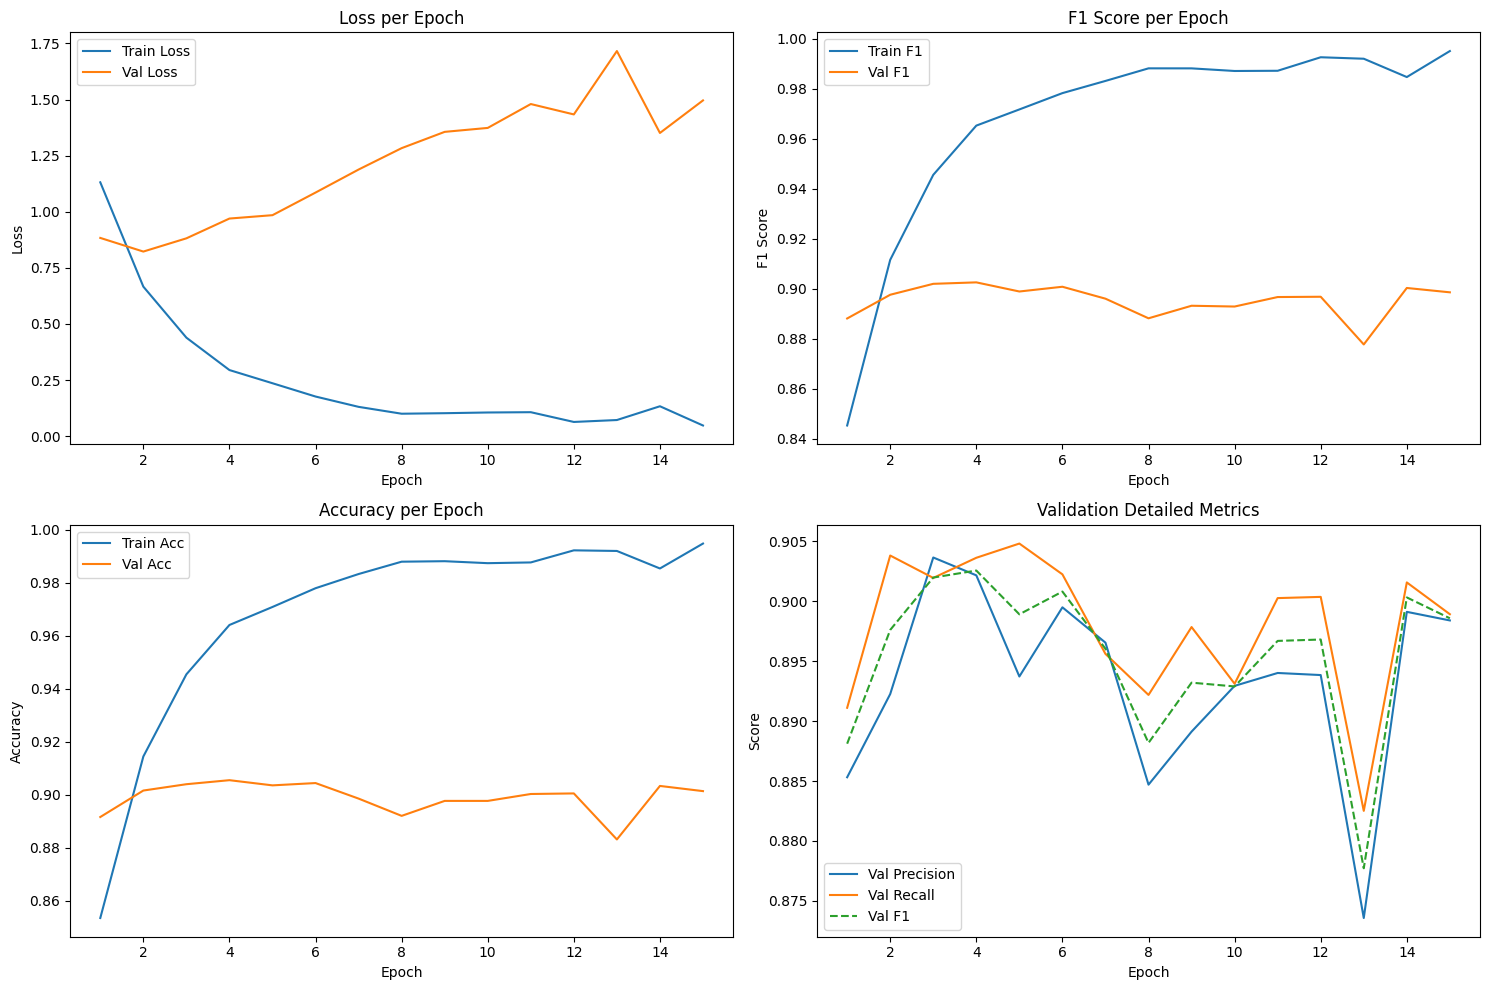

In [17]:
import matplotlib.pyplot as plt
# %matplotlib inline

plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(df_history['epoch'], df_history['train_loss'], label='Train Loss')
plt.plot(df_history['epoch'], df_history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# F1 Score
plt.subplot(2, 2, 2)
plt.plot(df_history['epoch'], df_history['train_f1'], label='Train F1')
plt.plot(df_history['epoch'], df_history['val_f1'], label='Val F1')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Accuracy
plt.subplot(2, 2, 3)
plt.plot(df_history['epoch'], df_history['train_acc'], label='Train Acc')
plt.plot(df_history['epoch'], df_history['val_acc'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Val Metrics Detailed
plt.subplot(2, 2, 4)
plt.plot(df_history['epoch'], df_history['val_pre'], label='Val Precision')
plt.plot(df_history['epoch'], df_history['val_rec'], label='Val Recall')
plt.plot(df_history['epoch'], df_history['val_f1'], label='Val F1', linestyle='--')
plt.title('Validation Detailed Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()